In [105]:
#First, we need to import all the libraries we need
import sklearn
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [106]:
#Next, we read in the Excel file
df = pd.read_excel (r'C:/Users/hruss/Desktop/OneDriveDocs/OneDrive/Documents/GMU/Datasets/heart.xlsx')

In [119]:
#Let's take a look at the head of the dataset
#df.head()
#Or the tail of it
df.tail()
#Or an overall view of types and missing values
#df.info()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
913,30,F,TA,170.0,237.0,0,ST,170,N,0.0,Up,0
914,43,F,TA,100.0,223.0,0,Normal,142,N,0.0,Up,0
915,62,F,TA,160.0,193.0,0,Normal,116,N,0.0,Up,0
916,34,M,TA,118.0,182.0,0,LVH,174,N,0.0,Up,0
917,35,F,TA,120.0,160.0,0,ST,185,N,0.0,Up,0


In [110]:
#CROSS VALIDATION #1: Split train/test dataset 80/20, without regard to class size
#Before we change anything at all on the dataset, we need to split into test and training sets.
#You want to know the true error rate on new untouched data, so you need an untouched set to test that
def split_train_test(data, test_ratio): 
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len( data)) 
    test_set_size = int(len( data) * test_ratio) 
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:] 
    return data.iloc[train_indices], data.iloc[test_indices]
train_set, test_set = split_train_test(df, 0.2) 
#len(train_set) 
len(test_set)

183

In [111]:
#CROSS VALIDATION #2: Split train/test dataset 80/20, ensuring representative class sizes for a column
#When you have uneven classes: in this case we have many more Male observations than Female
#In this case, we want to ensure that the training set and test set are representative of the full population
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42) 
for train_index, test_index in split.split(df, df["Sex"]): 
    strat_train_set = df.loc[train_index] 
    strat_test_set = df.loc[test_index]
strat_test_set["Sex"].value_counts() / len(strat_test_set)

M    0.788043
F    0.211957
Name: Sex, dtype: float64

In [112]:
#Double check the proportion of test data split to this population split
df["Sex"].value_counts() / len(df)

M    0.78976
F    0.21024
Name: Sex, dtype: float64

In [113]:
#Let's check describe again
strat_train_set.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,734.000000,730.000000,591.000000,734.000000,734.000000,734.000000,734.000000
mean,56.014986,132.650685,269.925550,0.241144,135.982289,0.910899,0.569482
std,35.790828,17.803836,310.772119,0.428069,25.576912,1.069363,0.495486
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,48.000000,120.000000,208.000000,0.000000,118.250000,0.000000,0.000000
50%,55.000000,130.000000,239.000000,0.000000,137.000000,0.700000,1.000000
75%,60.000000,140.000000,278.500000,0.000000,155.000000,1.575000,1.000000
max,660.000000,200.000000,6003.000000,1.000000,202.000000,6.200000,1.000000


In [114]:
#A few things are wrong with the training data. Let's fix those before we go further.
#First, the age values go up to 660. Based on life expetancy, we'll set the max to 77.
#Cholesterol also has some seriously high values. High risk is 600, let's cap at 800.
for x in strat_train_set.index:
    if strat_train_set.loc[x, "Cholesterol"] > 800:
        strat_train_set.loc[x, "Cholesterol"] = 800
    if strat_train_set.loc[x, "Age"] > 77:
        strat_train_set.loc[x, "Age"] = 77
    if strat_train_set.loc[x, "RestingBP"] < 50:
        strat_train_set.loc[x, "RestingBP"] = 50    
strat_train_set.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,734.000000,730.000000,591.000000,734.000000,734.000000,734.000000,734.000000
mean,53.904632,132.650685,249.099831,0.241144,135.982289,0.910899,0.569482
std,9.345084,17.803836,75.645999,0.428069,25.576912,1.069363,0.495486
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,48.000000,120.000000,208.000000,0.000000,118.250000,0.000000,0.000000
50%,55.000000,130.000000,239.000000,0.000000,137.000000,0.700000,1.000000
75%,60.000000,140.000000,278.500000,0.000000,155.000000,1.575000,1.000000
max,77.000000,200.000000,800.000000,1.000000,202.000000,6.200000,1.000000


In [115]:
#Let's see a count of nulls
strat_train_set.isnull().sum()

Age                 0
Sex                 0
ChestPainType       1
RestingBP           4
Cholesterol       143
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

In [116]:
#We impute missing values
strat_train_set['ChestPainType'].fillna(strat_train_set['ChestPainType'].value_counts().index[0], inplace=True)
strat_train_set['RestingBP'].fillna(strat_train_set['RestingBP'].mean(), inplace=True)
strat_train_set['Cholesterol'].fillna(strat_train_set['Cholesterol'].mean(), inplace=True)
strat_train_set.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [118]:
#Ordinal doesn't always work. In this case, we want 1 Hot encoding (1 is hot or true, 0 is not or false)
#You'll wind up with a sparse matrix because there will be a lot of zeros.
from sklearn.preprocessing import OneHotEncoder 
cat_encoder = OneHotEncoder() 
strat_train_1hot = cat_encoder.fit_transform(strat_train_set[['Sex', 'ChestPainType', 'ExerciseAngina', 'ST_Slope']]) 
enc_names = cat_encoder.get_feature_names_out()
strat_train_1hot_df = pd.DataFrame(strat_train_1hot.todense(), columns = enc_names)
train_tr = pd.merge(strat_train_1hot_df, strat_train_set.drop(['Sex', 'ChestPainType', 'ExerciseAngina', 'ST_Slope'], axis=1), left_index=True, right_index=True)
train_tr.head()

,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Age,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,Oldpeak,HeartDisease
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,62,160.0,164.0,0,LVH,145,6.2,1
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,55,140.0,217.0,0,Normal,111,5.6,1
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,61,120.0,282.0,0,ST,135,4.0,1
5,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,64,134.0,273.0,0,Normal,102,4.0,1
6,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,74,150.0,258.0,1,ST,130,4.0,1


<AxesSubplot:>

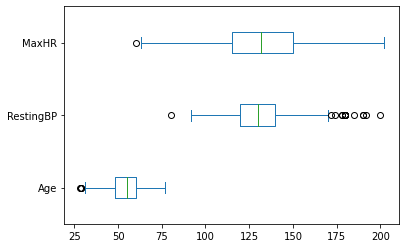

In [120]:
train_tr[['Age', 'RestingBP', 'MaxHR']].plot.box(vert = False)

array([[<AxesSubplot:xlabel='Age', ylabel='Age'>,
        <AxesSubplot:xlabel='RestingBP', ylabel='Age'>,
        <AxesSubplot:xlabel='Cholesterol', ylabel='Age'>,
        <AxesSubplot:xlabel='FastingBS', ylabel='Age'>,
        <AxesSubplot:xlabel='MaxHR', ylabel='Age'>],
       [<AxesSubplot:xlabel='Age', ylabel='RestingBP'>,
        <AxesSubplot:xlabel='RestingBP', ylabel='RestingBP'>,
        <AxesSubplot:xlabel='Cholesterol', ylabel='RestingBP'>,
        <AxesSubplot:xlabel='FastingBS', ylabel='RestingBP'>,
        <AxesSubplot:xlabel='MaxHR', ylabel='RestingBP'>],
       [<AxesSubplot:xlabel='Age', ylabel='Cholesterol'>,
        <AxesSubplot:xlabel='RestingBP', ylabel='Cholesterol'>,
        <AxesSubplot:xlabel='Cholesterol', ylabel='Cholesterol'>,
        <AxesSubplot:xlabel='FastingBS', ylabel='Cholesterol'>,
        <AxesSubplot:xlabel='MaxHR', ylabel='Cholesterol'>],
       [<AxesSubplot:xlabel='Age', ylabel='FastingBS'>,
        <AxesSubplot:xlabel='RestingBP', ylabel='Fastin

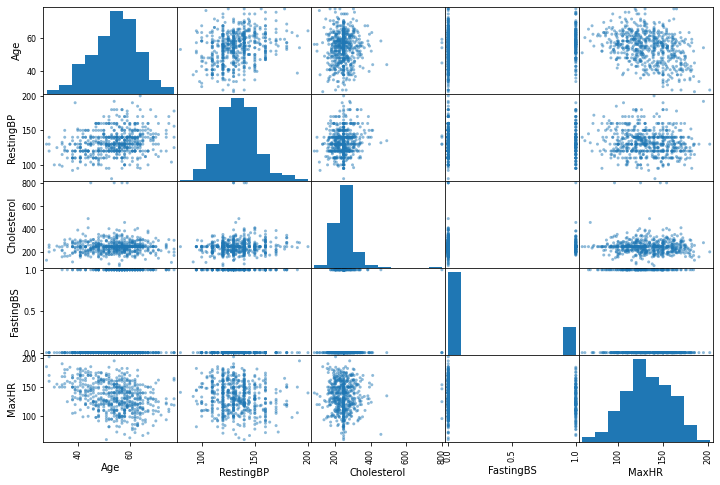

In [121]:
#Look at matrix of scatter plots
from pandas.plotting import scatter_matrix 
attributes = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR"] 
scatter_matrix(train_tr[ attributes], 
figsize =( 12, 8))


In [126]:
corr = train_tr[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR']].corr()
corr.style.background_gradient(cmap = 'BuGn').set_precision(4)

C:\Users\hruss\AppData\Local\Temp/ipykernel_3768/1715984040.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap = 'BuGn').set_precision(4)


,Age,RestingBP,Cholesterol,FastingBS,MaxHR
Age,1.0000,0.2563,0.0278,0.1655,-0.3640
RestingBP,0.2563,1.0000,0.1146,0.0397,-0.1216
Cholesterol,0.0278,0.1146,1.0000,0.0498,-0.0292
FastingBS,0.1655,0.0397,0.0498,1.0000,-0.1324
MaxHR,-0.3640,-0.1216,-0.0292,-0.1324,1.0000


Here are color codings we can use:
plot_color_gradients('Perceptually Uniform Sequential' ['viridis', 'plasma', 'inferno', 'magma', 'cividis'])
plot_color_gradients('Sequential', ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'])
plot_color_gradients('Sequential (2)', ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink', 'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper'])
plot_color_gradients('Diverging', ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic'])
plot_color_gradients('Qualitative', ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c'])
plot_color_gradients('Miscellaneous', ['flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral', 'gist_ncar'])

Text(0, 0.5, 'Age')

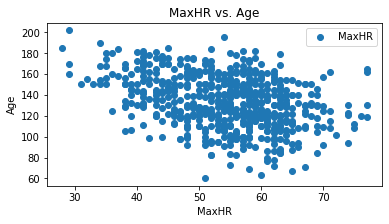

In [139]:
plt.figure(figsize=(6,3))
plt.scatter('Age', "MaxHR", data=train_tr)
plt.title("MaxHR vs. Age")
plt.legend()
plt.xlabel("MaxHR")
plt.ylabel("Age")

NameError: name 'angles' is not defined

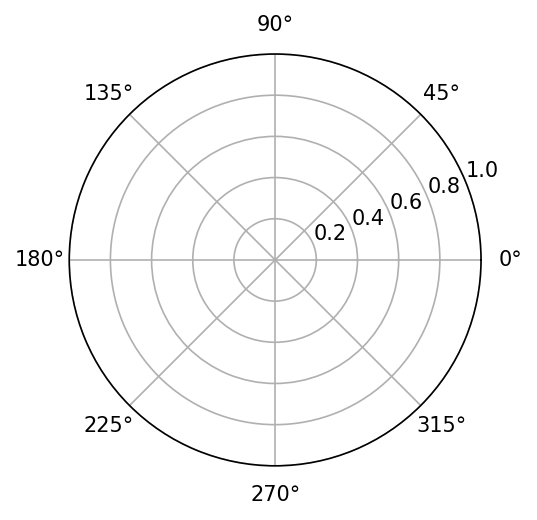

In [145]:
plt.figure(figsize=(8, 8), dpi = 150)
for i in range(4):
    ax = plt.subplot(2, 2, i+1, polar = True)
    ax.plot(angles, values[i])
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_xticks(angles)
    ax.set_xticklabels(attributes)
    ax.set_title(employees[i], fontsize = 14, color='r')
plt.tight_layout
plt.show()